# Disc Sports Twitter Sentiment Tracker

**Aim**
- Track tweet sentiment about Ultimate Frisbee over time

**Method**
- Access Twitter using _[Twython](https://pypi.org/project/twython/)_ and request tweets containing relevant hashtags
- Translate tweets in other languages to english using _[Googletrans](https://py-googletrans.readthedocs.io/en/latest)_
- Analyze tweets regarding expressed sentiment using _[VADER](http://www.nltk.org/api/nltk.sentiment.html#module-nltk.sentiment.vader)_ (from *NLTK*)
- Save processed data for future backup / update model only with new data
- Display in counts-over-time plot for each sentiment with daily/weekly resolution (maybe also ratio or other time slots)

**Documentation**
- [Guideline](https://towardsdatascience.com/almost-real-time-twitter-sentiment-analysis-with-tweep-vader-f88ed5b93b1c)
- [Twitter App page](https://developer.twitter.com/en/apps/18082193)

**Optional to do**
- Optimize retrieval (query a specific day instead of repeated "until" queries) - not needed due to automatic daily execution

### Notes
- Timezone of Twitter API timestamp is CET-2 (during summer time)
- Script is automated to run locally every day at a fixed time from a .py file
- secrets.txt needs the four secret keys (italic font: replace with actual value from https://developer.twitter.com)
    - Access token & access token secret
        - access_token,*Access token*
        - access_token_secret,*Access token secret*
    - Consumer API keys
        - api_key,*API key*
        - api_secret,*API secret key*

# Source Code

### Imports
- Import required modules
- Download VADER lexicon for sentiment analysis

In [2]:
import pandas as pd
import csv
import time
from datetime import date, timedelta
from nltk import download
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from twython import Twython
from twython import TwythonStreamer
from googletrans import Translator
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Johannes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Main code
- Set variables for extend of the querry
    - fetch_days: how many days into the past
    - only_en: only retrieve english tweets - if set to False, Google Translator is used
- Twitter API
    - only allows to retrieve from max. 7 days in the past
    - returns up to 100 tweets per query
    - query mode set to mixed (impact and how recent are considered)

#### Functionality
- Read existing csv collection of tweets
- Fetch tweets for 1-7 days in the past
    - Authenticate to Twitter API
    - Query for tweets
    - Translate tweets if not marked as english (optional)
    - Extract sentiment from tweet
    - Append query result to existing data
    - Drop duplicates
- Save merged dataframe in csv collection
- Show updated dataset size

In [3]:
fetch_days = 0 # max. 7 due to Twitter API
only_en = True
csv_file = r'tweets_frisbee.csv'

def extract_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(text)
    result = score['compound']
    if result >= 0.1:
        return 1
    elif (result < 0.1) and (result > -0.1):
        return 0
    elif result <= 0.1:
        return -1
    else:
        raise NameError('Invalid value of VADER compound')
        
def translate_tweet(text):
    translator = Translator()
    return translator.translate(text).text
        
def twitter_auth():
    with open(r'secrets.txt', 'r', newline='') as csvfile:
        d = {}
        reader = csv.reader(csvfile)
        for row in reader:
            k, v = row
            d[k] = v
        access_token = d['access_token']
        access_token_secret = d['access_token_secret']
        api_key = d['api_key']
        api_secret = d['api_secret']

    twitter = Twython(api_key, api_secret)
    # auth = twitter.get_authentication_tokens()
    # return twitter, auth['oauth_token'], auth['oauth_token_secret']
    return twitter

def tweet_search(search_word, skip_days=0, exclude_name=True):
    tweet_no = 0
    tweet_dict = {}
    queried_tweets = {}
    twitter = twitter_auth()
    since = (date.today() - timedelta(days=skip_days)).strftime('%Y-%m-%d')
    if only_en:
        statuses = twitter.search(q=search_word, count=100, until=since, lang='en')['statuses']
    else:
        statuses = twitter.search(q=search_word, count=100, until=since)['statuses']
    # until --> Returns tweets created before the given date. Date should be formatted as YYYY-MM-DD. Keep in mind that the search index has a 7-day limit. In other words, no tweets will be found for a date older than one week.
    for tweet in tqdm(statuses):
        user_name = tweet['user']['name']
        if exclude_name & (search_word in user_name):
            continue
        text = tweet['text']
        if (not only_en) and (tweet['lang'] != 'en'):
            try:
                text = translate_tweet(text)
            except:
                pass
        tweet_dict['id'] = tweet['id']
        tweet_dict['timestamp'] = time.strftime('%Y-%m-%d %H:%M:%S',
                                                time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y'))
        tweet_dict['sentiment'] = extract_sentiment(text)
        new_entry = {'tweet_dict_{}'.format(tweet_no): tweet_dict.copy()}
        queried_tweets.update(new_entry)
        tweet_dict.clear()
        tweet_no += 1
    print('Tweets retrieved with until={}'.format(since))
    return pd.DataFrame.from_dict(queried_tweets, orient='index', columns=['id', 'sentiment', 'timestamp'])

def read_csv():
    df = pd.read_csv(csv_file, index_col='id')
    df.index = df.index.astype('int64')
    df['timestamp'] = df.timestamp.astype('datetime64')
    print('Imported existing file: {}'.format(csv_file))
    return df

def save_to_csv(df):
    df.to_csv(csv_file, index=True)
    return

def fetch_new_tweets(fetch_days = 0, only_en = False):
    # Request tweets for the past x days, maximum is 7
    for days in range(fetch_days, -1, -1):
        query_result = tweet_search('frisbee', skip_days=days)
        query_result['id'] = query_result.id.astype('int64')
        query_result['timestamp'] = query_result.timestamp.astype('datetime64')
        query_result.set_index('id', inplace=True)
        ### query_result['timestamp'][query_result['timestamp'] < '2020-06-08 01:31:50'] # Possible to filter by timestamp
        df = df_old.append(query_result)
    return df

# Open csv file with past crawled tweets
try:
    df_old = read_csv()
except:
    df_old = pd.DataFrame()
    print('No file found under {}\n  --> creating new file'.format(csv_file))

df_new = fetch_new_tweets(fetch_days, only_en)
# Remove tweets that were already submitted earlier and safe enlargened dataset
df_new = df_new.drop_duplicates(ignore_index=False)
save_to_csv(df_new.sort_index(axis=0, ascending=False))

# Output information about updated database of tweets
print('\nNewest 3 entries:\n{}\n'.format(df_new.head(3)))
print('Number of new entries: {}'.format(df_new.shape[0] - df_old.shape[0]))
print('Total number of entries: {}'.format(df_new.shape[0]))
print('Positive tweets: {}'.format(df_new[df_new.sentiment == 1].sentiment.count()))
print('Neutral tweets: {}'.format(df_new[df_new.sentiment == 0].sentiment.count()))
print('Negative tweets: {}'.format(df_new[df_new.sentiment == -1].sentiment.count()))

Imported existing file: tweets_frisbee.csv


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 108.02it/s]

Tweets retrieved with until=2020-06-09

Newest 3 entries:
                     sentiment           timestamp
id                                                
1270139714247421952         -1 2020-06-08 23:44:40
1270138931959476226          1 2020-06-08 23:41:34
1270138714514239491          0 2020-06-08 23:40:42

Number of new entries: 5
Total number of entries: 1092
Positive tweets: 464
Neutral tweets: 392
Negative tweets: 236


### Visualization
- Show total counts and sentiment totals for each day

**Optional**
- Set week as xlabel instead of day of the year (display only on mondays)

In [4]:
sns.set_context('talk') # notebook / talk
#sns.set_style('white')

plotsavedir = './plots/'
def save_plot(plottitle: str, filenameinfo: str):
    """Save plot to png file."""
    filetype = '.png'
    plt.savefig(plotsavedir+plottitle.replace(' ','_')+'_'+filenameinfo+filetype, bbox_inches='tight')
    return

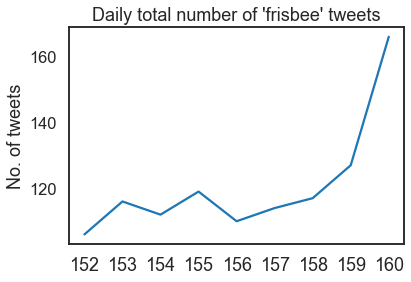

In [253]:
# Plot daily total number of tweets
show_every_nth_xlabel = 1
fig = df_new.timestamp.dt.date.value_counts().sort_index().plot()
# Only show every n-th label, using day of year
xlabels = list(df_new.timestamp.dt.dayofyear.sort_index().unique())
for _ in range(len(xlabels)):
    if (_)%show_every_nth_xlabel:
        xlabels[_] = ''
    else:
        continue
xticklabels = fig.set_xticklabels(xlabels, fontdict = {'fontsize': plt.rcParams['axes.titlesize'],
                                'fontweight': plt.rcParams['axes.titleweight'], 'va': 'top', 'ha': 'center'})
ylabel = plt.ylabel('No. of tweets')
title = fig.set_title('Daily total number of \'frisbee\' tweets')
save_plot(fig.get_title(), str(date.today()))
save_plot(fig.get_title(), 'latest')
plt.show()

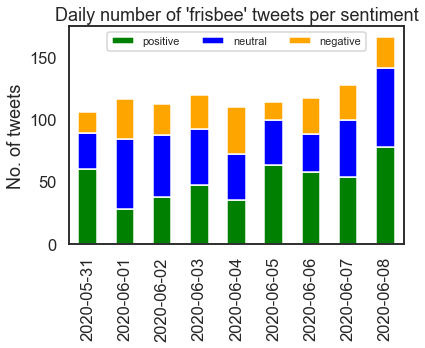

In [246]:
# Plot daily number of tweets per sentiment
plotdata = pd.DataFrame({
    'positive':df_new[(df_new.sentiment == 1)].timestamp.dt.date.value_counts().sort_index(),
    'neutral':df_new[(df_new.sentiment == 0)].timestamp.dt.date.value_counts().sort_index(),
    'negative':df_new[(df_new.sentiment == -1)].timestamp.dt.date.value_counts().sort_index()})

fig = plotdata.plot(kind='bar', stacked=True, color=['green', 'blue', 'orange'])
ylabel = plt.ylabel('No. of tweets')
title = fig.set_title('Daily number of \'frisbee\' tweets per sentiment')
legend = fig.legend(loc='upper center', ncol=3, fontsize=11)
save_plot(fig.get_title(), str(date.today()))
save_plot(fig.get_title(), 'latest')
plt.show()

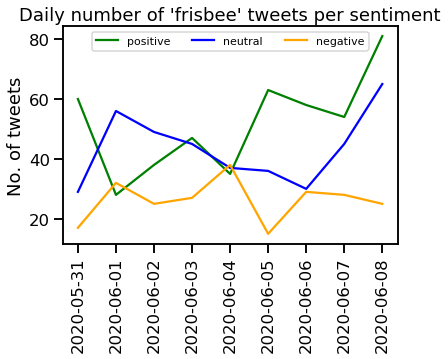

In [6]:
# Plot daily number of tweets per sentiment
plotdata = pd.DataFrame({
    'positive':df_new[(df_new.sentiment == 1)].timestamp.dt.date.value_counts().sort_index(),
    'neutral':df_new[(df_new.sentiment == 0)].timestamp.dt.date.value_counts().sort_index(),
    'negative':df_new[(df_new.sentiment == -1)].timestamp.dt.date.value_counts().sort_index()})

fig = plotdata.plot(kind='line', color=['green', 'blue', 'orange'])
ylabel = plt.ylabel('No. of tweets')
title = fig.set_title('Daily number of \'frisbee\' tweets per sentiment')
legend = fig.legend(loc='upper center', ncol=3, fontsize=11)
xticks = plt.xticks(rotation=90)
save_plot(fig.get_title(), 'line_'+str(date.today()))
save_plot(fig.get_title(), 'line_latest')
plt.show()